In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split
from datetime import datetime

In [2]:
#Make a plot with stock name
def plot_predictions(test,predicted, stock):
    plt.plot(test, color='red',label=stock+' Stock Price')
    plt.plot(predicted, color='blue',label='Predicted '+stock+' Stock Price')
    plt.title(stock+' Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(stock+' Stock Price')
    plt.legend()
    plt.show()

In [3]:
dataset = pd.read_csv('../input/row-stocks/WMT.csv')
dataset.head()
stock = 'Walmart'

In [4]:
date_test_coeff = 0.8
split = int(len(dataset)*date_test_coeff)

In [5]:
data = []

path = '../input/row-stocks/BA.csv'
df = pd.read_csv(path, sep=',')
df['Date'] = pd.to_datetime(df['Date'])
data.append(df)


In [6]:
del df['Adj Close']

In [7]:
d1, d2, d3, d4 = dataset.iloc[0], dataset.iloc[split], dataset.iloc[split+1], dataset.iloc[len(dataset)-1]

train_start, train_end, test_start, test_end = d1.Date, d2.Date, d3.Date, d4.Date

print(train_start, train_end, test_start, test_end)

dataset.Date = pd.to_datetime(dataset.Date, format='%Y-%m-%d')
data_plot = pd.DataFrame({'Close': dataset.Close.values},
                  index=dataset.Date)

2004-05-10 2017-12-12 2017-12-13 2021-05-07


In [8]:
# Checking for missing values
training_set = dataset[0:split].iloc[:,1:2].values
test_set = dataset[split+1:len(dataset)-1].iloc[:,1:2].values

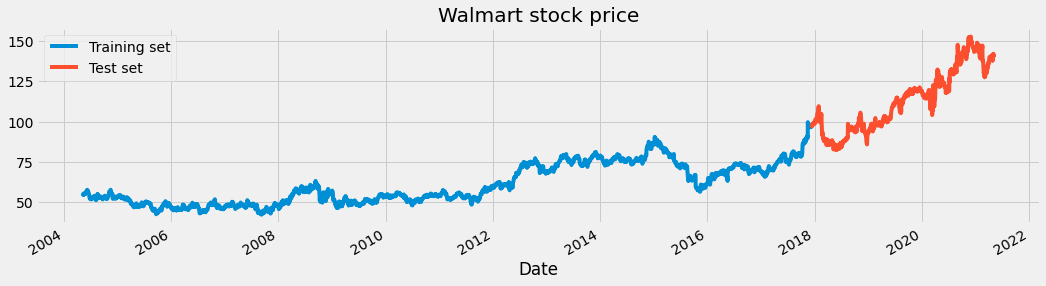

In [9]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
data_plot["Close"][:split].plot(figsize=(16,4),legend=True)
data_plot["Close"][split:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title(stock+' stock price')
plt.show()


In [10]:
training_set.shape


(3423, 1)

In [11]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [12]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,training_set.shape[0]):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train.shape

(3363, 60)

In [14]:
y_train.shape

(3363,)

In [15]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [16]:
X_train.shape

(3363, 60, 1)

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
106/106 [==============================] - 18s 105ms/step - loss: 0.0205
Epoch 2/50
106/106 [==============================] - 11s 107ms/step - loss: 0.0053
Epoch 3/50
106/106 [==============================] - 12s 114ms/step - loss: 0.0037
Epoch 4/50
106/106 [==============================] - 12s 111ms/step - loss: 0.0036
Epoch 5/50
106/106 [==============================] - 11s 108ms/step - loss: 0.0027
Epoch 6/50
106/106 [==============================] - 11s 107ms/step - loss: 0.0028
Epoch 7/50
106/106 [==============================] - 11s 105ms/step - loss: 0.0022
Epoch 8/50
106/106 [==============================] - 11s 107ms/step - loss: 0.0026
Epoch 9/50
106/106 [==============================] - 12s 109ms/step - loss: 0.0019
Epoch 10/50
106/106 [==============================] - 11s 107ms/step - loss: 0.0018
Epoch 11/50
106/106 [==============================] - 11s 106ms/step - loss: 0.0018
Epoch 12/50
106/106 [==============================] - 12s 108ms/step - lo

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = data_plot.copy()
#pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
training_set.shape[0]

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
predicted_stock_price.shape

In [ ]:
test_set.shape

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price, stock)

In [ ]:
# Evaluating our model
#return_rmse(test_set,predicted_stock_price)
mse = mean_squared_error(test_set, predicted_stock_price)
#print('MSE: '+f'{mse:.6f}')
print(f'{mse:.6f}')
mae = mean_absolute_error(test_set, predicted_stock_price)
print(f'{mae:.6f}')
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print(f'{rmse:.6f}')
mape = np.mean(np.abs(predicted_stock_price - test_set)/np.abs(test_set))
print(f'{mape:.6f}')